In [1]:
# !pip install lazypredict
# !pip install librosa

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

# Dataset: Hearts (HS)

In [3]:
df_hearts = pd.read_csv("HS.csv")
df_hearts.head(10)

,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB
5,F,Normal,Apex,F_N_A
6,M,Late Diastolic Murmur,LC,M_LDM_LC
7,M,Mid Systolic Murmur,Apex,M_MSM_A
8,F,Normal,RUSB,F_N_RUSB
9,F,Mid Systolic Murmur,Apex,F_MSM_A


In [4]:
df_hearts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            50 non-null     object
 1   Heart Sound Type  50 non-null     object
 2   Location          50 non-null     object
 3   Heart Sound ID    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [5]:
df_hearts.shape

(50, 4)

In [6]:
# Bir sınıf tanımlayıp yeni özellikler çıkarımlarını bu sınıfla yapacağız. TransformerMixin sınıfı ile bu sınıfı pipeline uyumlu bir sınıf haline getiriyoruz.
# We will define a class and infer new features using this class. We are making this class pipeline-compatible using the TransformerMixin class.

from sklearn.base import BaseEstimator, TransformerMixin 

In [7]:
# Özelliklere hakim olmak için transformatörlerin çıktılarını tablo halinde geri istiyoruz. (Çıktılar genellikle numpy dizisi olur. Fakat yeni özellikler üreteceğimiz için numpy dizisinde yeni özelliklerin takibini yapmak güç olur.)
# To better understand the properties, we need the transformer outputs back in tabular form. (The outputs are usually numpy arrays. However, since we will be generating new properties, it can be difficult to keep track of new properties in a numpy array.)

from sklearn import set_config
set_config(transform_output="pandas")

In [8]:
# Ses dosyalarını işleyebilmek için 'librosa' kütüphanesini kullanarak mevcut sesi temsil eden birtakım özellikler çıkartacağız. Bu özellikler mevcut sese ait ele alacağımız veriler olacak.
# To process audio files, we will use the 'librosa' library to extract a number of features representing the existing audio. These features will be the data we will analyze regarding the audio.

class SoundFeatureExtraction(BaseEstimator, TransformerMixin): # TransformerMixin: İleriye dönük pipeline hazırlığı. / # Forward pipeline preparation.

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X_copy = X.copy()
        X_copy.columns = X_copy.columns.str.replace(" ", "_")
        sound_features = []
        features = {}
        
        for sound_file in X_copy["Heart_Sound_ID"]:
            
            sound, sample_rate = librosa.load(f"SoundsHearts/{sound_file}.wav")

            zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y=sound))
            zero_crossing_rate_std = np.std(librosa.feature.zero_crossing_rate(y=sound))
            spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=sound, sr=sample_rate))
            spectral_centroid_std = np.std(librosa.feature.spectral_centroid(y=sound, sr=sample_rate))

            mfcc = librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=20) # 20 farklı mfcc özelliği döndürür. / # Returns 20 different MFCC attributes.
            delta = librosa.feature.delta(mfcc) # 20 farklı delta özelliği döndürür. / # Returns 20 different delta properties.
            delta2 = librosa.feature.delta(mfcc, order=2) # 20 farklı delta2 özelliği döndürür. / # Returns 20 different delta2 properties.

            features = {

                "zcr_mean" :zero_crossing_rate_mean,
                "zcr_std" : zero_crossing_rate_std,
                "spactral_centroid_mean" : spectral_centroid_mean,
                "spactral_centroid_std" : spectral_centroid_std
                
            }

            for i in range(20):
                features[f"mfcc_mean_{i}"] = np.mean(mfcc[i])
                features[f"mfcc_std_{i}"] = np.std(mfcc[i])
                features[f"delta_mean_{i}"] = np.mean(delta[i])
                features[f"delta2_mean_{i}"] = np.mean(delta2[i])

            sound_features.append(features)
            
        X_copy = X_copy.drop(columns="Heart_Sound_ID")
        X_features = pd.DataFrame(sound_features)

        X_final = pd.concat([X_copy, X_features], axis=1)



        return X_final

In [9]:
sound_transformer = SoundFeatureExtraction()
df_hearts_sound_transformed = sound_transformer.transform(df_hearts)
df_hearts_sound_transformed.head()

,Gender,Heart_Sound_Type,Location,zcr_mean,zcr_std,spactral_centroid_mean,spactral_centroid_std,mfcc_mean_0,mfcc_std_0,delta_mean_0,...,delta_mean_17,delta2_mean_17,mfcc_mean_18,mfcc_std_18,delta_mean_18,delta2_mean_18,mfcc_mean_19,mfcc_std_19,delta_mean_19,delta2_mean_19
0,F,Normal,RC,0.011865,0.003641,197.533892,79.369334,-811.743103,21.899385,-0.064974,...,0.007365,0.002719,3.721206,3.429805,0.007193,0.000010,1.460268,2.976980,0.000916,0.001423
1,F,Normal,LC,0.005292,0.002029,126.263296,74.902719,-739.999390,20.036757,-0.106567,...,-0.000856,-0.002748,7.830595,2.388463,-0.001659,-0.005153,7.545056,2.305463,-0.002225,-0.005119
2,M,Normal,RUSB,0.006299,0.002997,138.829129,76.044352,-642.830017,26.657543,0.065820,...,0.003267,0.004706,4.988845,2.466963,-0.000345,0.005607,4.503294,2.146452,-0.003315,0.005648
3,F,Normal,LUSB,0.006954,0.002613,153.336816,67.241310,-735.806091,40.153576,0.042557,...,0.006954,-0.006066,6.437358,2.675262,0.003366,-0.007799,6.631809,2.528942,0.000887,-0.007322
4,F,Normal,LLSB,0.007949,0.003386,163.578392,70.967673,-717.262085,38.456963,-0.248626,...,0.003655,-0.004480,5.741099,3.036964,0.008324,-0.005841,5.402651,3.200303,0.010287,-0.006491


In [10]:
print(df_hearts.shape)
print(df_hearts_sound_transformed.shape)

(50, 4)
(50, 87)


In [11]:
df_hearts["Location"].unique()

array(['RC', 'LC', 'RUSB', 'LUSB', 'LLSB', 'Apex'], dtype=object)

In [12]:
# Ses kayıtlarının alındığı bölgeler hastalık tespiti konusunda önem arz ediyor. Bu yüzden tanımlanan bölgelere karşılık gelen tüm konumları özellik olarak tabloya ekliyoruz.
# The regions where audio recordings were taken are important for disease detection. Therefore, we are adding all locations corresponding to the defined regions as features to the table.

class LocationFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self):

        self.mapping = {
    
        "Apex" : "apex",
        "LC" : "left,carotid",
        "LLSB" : "left,lower,sternal_border",
        "LUSB" : "left,upper,sternal_border",
        "RC" : "right,carotid",
        "RUSB" : "right,upper,sternal_border",
        }

        self.location_features = ["apex", "carotid", "left", "lower", "right", "sternal_border", "upper"] 

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X_copy = X.copy()
        
        dummies_mapping = X_copy["Location"].map(self.mapping)
        dummies_data = dummies_mapping.str.get_dummies(sep=",")

        dummies_data = dummies_data.reindex(columns=self.location_features, fill_value=0) # Canlı kullanım için tek satırlık veri girişi yapıldığında pipeline akışını garanti altına aldık. Aksi takdirde eksik kolon hatası verecekti.
                                                                                          # We ensured pipeline flow when only one row of data was entered for live use. Otherwise, it would give a missing column error.
        X_copy = X_copy.drop(columns="Location", axis=1)

        X_final = pd.concat([X_copy, dummies_data], axis=1)

        return X_final

In [13]:
location_transformer = LocationFeatureExtraction()
df_hearts_all_transformed_final = location_transformer.transform(df_hearts_sound_transformed)
df_hearts_all_transformed_final.head()

,Gender,Heart_Sound_Type,zcr_mean,zcr_std,spactral_centroid_mean,spactral_centroid_std,mfcc_mean_0,mfcc_std_0,delta_mean_0,delta2_mean_0,...,mfcc_std_19,delta_mean_19,delta2_mean_19,apex,carotid,left,lower,right,sternal_border,upper
0,F,Normal,0.011865,0.003641,197.533892,79.369334,-811.743103,21.899385,-0.064974,0.181478,...,2.976980,0.000916,0.001423,0,1,0,0,1,0,0
1,F,Normal,0.005292,0.002029,126.263296,74.902719,-739.999390,20.036757,-0.106567,0.149515,...,2.305463,-0.002225,-0.005119,0,1,1,0,0,0,0
2,M,Normal,0.006299,0.002997,138.829129,76.044352,-642.830017,26.657543,0.065820,-0.053987,...,2.146452,-0.003315,0.005648,0,0,0,0,1,1,1
3,F,Normal,0.006954,0.002613,153.336816,67.241310,-735.806091,40.153576,0.042557,0.016550,...,2.528942,0.000887,-0.007322,0,0,1,0,0,1,1
4,F,Normal,0.007949,0.003386,163.578392,70.967673,-717.262085,38.456963,-0.248626,0.040912,...,3.200303,0.010287,-0.006491,0,0,1,1,0,1,0


In [14]:
print(df_hearts.shape)
print(df_hearts_sound_transformed.shape)
print(df_hearts_all_transformed_final.shape)

(50, 4)
(50, 87)
(50, 93)


In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Label Encoding: Heart_Sound_Type (target)
# One Hot Encoding: Gender
# Standart Scaler: # Ses örneklerinden çıkartılan tüm özellikler. / # All features extracted from the audio samples.

In [16]:
print(df_hearts_all_transformed_final["Heart_Sound_Type"].unique(), "\n")

label_encoding = LabelEncoder()
df_hearts_all_transformed_final["Heart_Sound_Type"] = label_encoding.fit_transform(df_hearts_all_transformed_final["Heart_Sound_Type"])

print(df_hearts_all_transformed_final["Heart_Sound_Type"].unique())

['Normal' 'Late Diastolic Murmur' 'Mid Systolic Murmur'
 'Late Systolic Murmur' 'Atrial Fibrillation' 'S4' 'Early Systolic Murmur'
 'S3' 'Tachycardia' 'AV Block'] 

[6 3 5 4 1 8 2 7 9 0]


In [17]:
X_hearts = df_hearts_all_transformed_final.drop(columns="Heart_Sound_Type")
y_hearts = df_hearts_all_transformed_final["Heart_Sound_Type"]

In [18]:
from sklearn.compose import make_column_selector # Özellik sayısı fazlalaştı, bu yüzden işleme tabi tutulan kolonları filtreleyeceğiz.

ct_hearts = ColumnTransformer(transformers=[
    
    ("encoding", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Gender"]),
    ("scaling", StandardScaler(), make_column_selector(pattern="^zcr|spactral|mfcc|delta|delta2.*")) # Belirli özellik isimleriyle başlayan kolonları filtreledik. (Burada 'set_config(transform_output="pandas")' ayarının önemi öne çıkıyor.)
                                                                                       # We filtered columns that start with specific attribute names. (This is where the 'set_config(transform_output="pandas")' setting comes into play.)
    
], remainder="passthrough")

In [19]:
y_hearts.value_counts()

Heart_Sound_Type
6    9
5    7
3    6
2    6
4    5
7    5
1    4
9    3
0    3
8    2
Name: count, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_hearts, y_hearts, test_size=0.33, random_state=42, stratify=y_hearts)

In [21]:
X_train = ct_hearts.fit_transform(X_train)
X_test = ct_hearts.transform(X_test)

In [22]:
X_train.head()

,encoding__Gender_F,encoding__Gender_M,scaling__zcr_mean,scaling__zcr_std,scaling__spactral_centroid_mean,scaling__spactral_centroid_std,scaling__mfcc_mean_0,scaling__mfcc_std_0,scaling__delta_mean_0,scaling__delta2_mean_0,...,scaling__mfcc_std_19,scaling__delta_mean_19,scaling__delta2_mean_19,remainder__apex,remainder__carotid,remainder__left,remainder__lower,remainder__right,remainder__sternal_border,remainder__upper
38,0.0,1.0,0.625476,1.223051,0.618492,1.586787,0.567397,2.093953,0.139869,-0.519946,...,-0.673974,0.391173,0.162838,0,0,1,0,0,1,1
39,1.0,0.0,-0.031137,-0.674818,-0.721355,0.263358,1.443184,1.454921,-0.903508,-0.510930,...,0.296290,1.973152,0.588474,0,0,1,1,0,1,0
13,1.0,0.0,0.643435,1.484404,0.770892,0.864874,-0.545548,0.296569,1.947011,-0.683398,...,0.246919,-0.104840,1.070881,1,0,0,0,0,0,0
5,1.0,0.0,-0.629841,-0.906716,-0.385457,0.186279,-0.332354,-0.479671,-1.168504,2.257392,...,-1.199014,-0.533976,-1.174939,1,0,0,0,0,0,0
6,0.0,1.0,0.015594,0.082951,0.055071,-1.183631,-0.865436,0.612089,-1.136596,0.723966,...,2.315987,1.801366,0.383308,0,1,1,0,0,0,0


In [23]:
# Lazy Predict ile veriseti için en uygun algoritmayı belirliyoruz.
# We determine the most suitable algorithm for the dataset with Lazy Predict.

from lazypredict.Supervised import LazyClassifier
lazy = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

model_table, pred = lazy.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 33, number of used features: 0
[LightGBM] [Info] Start training from score -2.803360
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.110213
[LightGBM] [Info] Start training from score -2.110213
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -1.887070
[LightGBM] [Info] Start training from score -1.704748
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -3.496508
[LightGBM] [Info] Start training from score -2.803360
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warnin

In [24]:
model_table.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.41,0.35,None,0.36,0.01
LogisticRegression,0.41,0.35,None,0.37,0.18
RandomForestClassifier,0.41,0.33,None,0.37,0.08
PassiveAggressiveClassifier,0.35,0.30,None,0.33,0.01
NearestCentroid,0.35,0.30,None,0.35,0.01
LinearSVC,0.35,0.30,None,0.33,0.02
RidgeClassifier,0.35,0.30,None,0.32,0.02
RidgeClassifierCV,0.35,0.30,None,0.34,0.01
LinearDiscriminantAnalysis,0.35,0.28,None,0.34,0.03


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logistic_reg = LogisticRegression(class_weight='balanced')
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

df_hearts_score = accuracy_score(y_test, y_pred)

Accuracy Score:  0.4117647058823529 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.67      1.00      0.80         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       0.67      1.00      0.80         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.41        17
   macro avg       0.30      0.35      0.31        17
weighted avg       0.35      0.41      0.36        17



In [26]:
# Hearts veri setindeki (HS.csv) skorların düşük olmasına etki eden unsurun veri setinin küçük olması olduğunu varsayarak diğer veri setine (Mix.csv) göz atacağız.
# Assuming that the reason for the low scores in the Hearts dataset (HS.csv) is the small size of the dataset, we will now examine the other dataset (Mix.csv).

# Dataset: Mix (Mix.csv)

In [27]:
df_mix = pd.read_csv("Mix.csv")
df_mix.head(10)

# Bu veri setinde aynı zamanda akciğer ses kayıtları da mevcut ve onları kaldırıp sadece kalp ile ilgili özellikleri tutacağız. Bunun nedeni akciğer seslerinin noise (gürültü) yaratma potansiyelinin olmasıdır.
# This dataset also includes lung sound recordings, and we will remove them, keeping only the heart-related features. This is because lung sounds have the potential to create noise.

,Gender,Heart Sound Type,Lung Sound Type,Location,Heart Sound ID,Lung Sound ID,Mixed Sound ID
0,F,Late Systolic Murmur,Rhonchi,LUSB,H0001,L0001,M0001
1,F,S3,Normal,RLA,H0002,L0002,M0002
2,M,Atrial Fibrillation,Normal,LMA,H0003,L0003,M0003
3,F,S3,Coarse Crackles,Apex,H0004,L0004,M0004
4,M,AV Block,Fine Crackles,RUSB,H0005,L0005,M0005
5,F,S3,Pleural Rub,RC,H0006,L0006,M0006
6,M,Tachycardia,Pleural Rub,Apex,H0007,L0007,M0007
7,F,Early Systolic Murmur,Pleural Rub,LMA,H0008,L0008,M0008
8,M,Mid Systolic Murmur,Wheezing,LUA,H0009,L0009,M0009
9,F,Early Systolic Murmur,Coarse Crackles,LUA,H0010,L0010,M0010


In [28]:
df_mix = df_mix.drop(columns=["Lung Sound Type", "Lung Sound ID", "Mixed Sound ID"])
df_mix.head()

,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Late Systolic Murmur,LUSB,H0001
1,F,S3,RLA,H0002
2,M,Atrial Fibrillation,LMA,H0003
3,F,S3,Apex,H0004
4,M,AV Block,RUSB,H0005


In [29]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            145 non-null    object
 1   Heart Sound Type  145 non-null    object
 2   Location          145 non-null    object
 3   Heart Sound ID    145 non-null    object
dtypes: object(4)
memory usage: 4.7+ KB


In [30]:
print(df_hearts.shape)
print(df_mix.shape)

(50, 4)
(145, 4)


In [31]:
# Mix veri setine ait seslerin konumlarını düzenleyerek sınıfı güncelliyoruz.
# We are updating the class by rearranging the locations of the audio tracks in the Mix dataset.

class SoundFeatureExtraction(BaseEstimator, TransformerMixin): 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X_copy = X.copy()
        X_copy.columns = X_copy.columns.str.replace(" ", "_")
        sound_features = []
        features = {}
        
        for sound_file in X_copy["Heart_Sound_ID"]:
            
            sound, sample_rate = librosa.load(f"SoundsMix/{sound_file}.wav") ###

            zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y=sound))
            zero_crossing_rate_std = np.std(librosa.feature.zero_crossing_rate(y=sound))
            spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=sound, sr=sample_rate))
            spectral_centroid_std = np.std(librosa.feature.spectral_centroid(y=sound, sr=sample_rate))

            mfcc = librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=20)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)

            features = {

                "zcr_mean" :zero_crossing_rate_mean,
                "zcr_std" : zero_crossing_rate_std,
                "spactral_centroid_mean" : spectral_centroid_mean,
                "spactral_centroid_std" : spectral_centroid_std
                
            }

            for i in range(20):
                features[f"mfcc_mean_{i}"] = np.mean(mfcc[i])
                features[f"mfcc_std_{i}"] = np.std(mfcc[i])
                features[f"delta_mean_{i}"] = np.mean(delta[i])
                features[f"delta2_mean_{i}"] = np.mean(delta2[i])

            sound_features.append(features)
            
        X_copy = X_copy.drop(columns="Heart_Sound_ID")
        X_features = pd.DataFrame(sound_features)

        X_final = pd.concat([X_copy, X_features], axis=1)



        return X_final

In [32]:
sound_transformer = SoundFeatureExtraction()
df_mix_sound_transformer = sound_transformer.transform(df_mix)
df_mix_sound_transformer.head()

,Gender,Heart_Sound_Type,Location,zcr_mean,zcr_std,spactral_centroid_mean,spactral_centroid_std,mfcc_mean_0,mfcc_std_0,delta_mean_0,...,delta_mean_17,delta2_mean_17,mfcc_mean_18,mfcc_std_18,delta_mean_18,delta2_mean_18,mfcc_mean_19,mfcc_std_19,delta_mean_19,delta2_mean_19
0,F,Late Systolic Murmur,LUSB,0.02,0.01,323.86,91.24,-778.02,48.58,-0.14,...,0.01,0.01,2.45,3.87,0.00,0.00,-0.21,3.24,-0.00,0.01
1,F,S3,RLA,0.01,0.00,113.84,35.79,-737.83,28.67,0.01,...,0.00,0.01,5.21,2.69,0.01,0.01,5.59,2.99,0.01,0.00
2,M,Atrial Fibrillation,LMA,0.01,0.00,151.89,102.23,-647.10,33.87,-0.15,...,-0.01,0.01,6.95,2.88,-0.00,0.00,6.73,2.52,-0.00,0.00
3,F,S3,Apex,0.01,0.00,139.95,53.59,-755.35,33.76,0.11,...,-0.01,0.00,4.44,4.26,-0.01,0.00,4.75,3.76,-0.01,-0.00
4,M,AV Block,RUSB,0.00,0.00,90.29,46.87,-661.57,25.01,-0.19,...,-0.01,-0.00,4.65,3.04,-0.00,-0.01,4.07,2.86,-0.00,-0.01


In [33]:
print(df_hearts_sound_transformed.shape)
print(df_mix_sound_transformer.shape)

(50, 87)
(145, 87)


In [34]:
df_mix["Location"].unique()

array(['LUSB', 'RLA', 'LMA', 'Apex', 'RUSB', 'RC', 'LUA', 'RMA', 'RUA',
       'LC', 'LLSB', 'LLA'], dtype=object)

In [35]:
df_hearts["Location"].unique()

array(['RC', 'LC', 'RUSB', 'LUSB', 'LLSB', 'Apex'], dtype=object)

In [36]:
# Mix veri setinde yeni kayıt bölgeleri olduğunu tespit edip bu yeni bölgelerin bilgilerini güncelliyoruz.
# We identify new record regions in the Mix dataset and update the information for these new regions.

class LocationFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self):

        self.mapping = {
    
        "Apex" : "apex",
        "LC" : "left,carotid",
        "LLSB" : "left,lower,sternal_border",
        "LUSB" : "left,upper,sternal_border",
        "RC" : "right,carotid",
        "RUSB" : "right,upper,sternal_border",
        'LUA': 'left,upper,anterior', # New
        'RUA': 'right,upper,anterior', # New
        'LMA': 'left,mid,anterior', # New
        'RMA': 'right,mid,anterior', # New
        'LLA': 'left,lower,anterior', # New
        'RLA': 'right,lower,anterior' # New
        }

        self.location_features = ["anterior", "apex", "carotid", "left", "lower", "mid", "right", "sternal_border", "upper"] 

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X_copy = X.copy()
        
        dummies_mapping = X_copy["Location"].map(self.mapping)
        dummies_data = dummies_mapping.str.get_dummies(sep=",")

        dummies_data = dummies_data.reindex(columns=self.location_features, fill_value=0)
                                                                                         
        X_copy = X_copy.drop(columns="Location", axis=1)

        X_final = pd.concat([X_copy, dummies_data], axis=1)

        return X_final

In [37]:
location_transformer = LocationFeatureExtraction()
df_mix_all_transformed_final = location_transformer.transform(df_mix_sound_transformer)
df_mix_all_transformed_final.head(10)

,Gender,Heart_Sound_Type,zcr_mean,zcr_std,spactral_centroid_mean,spactral_centroid_std,mfcc_mean_0,mfcc_std_0,delta_mean_0,delta2_mean_0,...,delta2_mean_19,anterior,apex,carotid,left,lower,mid,right,sternal_border,upper
0,F,Late Systolic Murmur,0.02,0.01,323.86,91.24,-778.02,48.58,-0.14,-0.06,...,0.01,0,0,0,1,0,0,0,1,1
1,F,S3,0.01,0.00,113.84,35.79,-737.83,28.67,0.01,-0.09,...,0.00,1,0,0,0,1,0,1,0,0
2,M,Atrial Fibrillation,0.01,0.00,151.89,102.23,-647.10,33.87,-0.15,0.01,...,0.00,1,0,0,1,0,1,0,0,0
3,F,S3,0.01,0.00,139.95,53.59,-755.35,33.76,0.11,0.16,...,-0.00,0,1,0,0,0,0,0,0,0
4,M,AV Block,0.00,0.00,90.29,46.87,-661.57,25.01,-0.19,0.06,...,-0.01,0,0,0,0,0,0,1,1,1
5,F,S3,0.02,0.01,292.44,84.04,-861.92,29.25,0.11,-0.04,...,0.01,0,0,1,0,0,0,1,0,0
6,M,Tachycardia,0.01,0.00,215.12,65.61,-767.37,28.46,-0.01,0.08,...,-0.01,0,1,0,0,0,0,0,0,0
7,F,Early Systolic Murmur,0.01,0.01,262.66,85.35,-743.40,25.64,-0.13,-0.00,...,-0.00,1,0,0,1,0,1,0,0,0
8,M,Mid Systolic Murmur,0.02,0.01,334.65,66.29,-868.56,22.05,0.00,-0.09,...,0.00,1,0,0,1,0,0,0,0,1
9,F,Early Systolic Murmur,0.01,0.00,212.52,79.47,-629.60,21.62,0.02,-0.04,...,-0.00,1,0,0,1,0,0,0,0,1


In [38]:
print(df_mix.shape)
print(df_mix_sound_transformer.shape)
print(df_mix_all_transformed_final.shape)

(145, 4)
(145, 87)
(145, 95)


In [39]:
label_encoding = LabelEncoder()
df_mix_all_transformed_final["Heart_Sound_Type"] = label_encoding.fit_transform(df_mix_all_transformed_final["Heart_Sound_Type"])

In [40]:
X_mix = df_mix_all_transformed_final.drop(columns="Heart_Sound_Type")
y_mix = df_mix_all_transformed_final["Heart_Sound_Type"]

In [41]:
y_mix.value_counts()

Heart_Sound_Type
4    17
9    16
8    16
7    15
1    15
5    14
0    13
2    13
3    13
6    13
Name: count, dtype: int64

In [42]:
ct_mix = ColumnTransformer(transformers=[
    
    ("encoding", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Gender"]),
    ("scaling", StandardScaler(), make_column_selector(pattern="^zcr|spactral|mfcc|delta|delta2.*"))
                                                                                       
    
], remainder="passthrough")

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_mix, y_mix, test_size=0.33, random_state=42, stratify=y_mix) # Veri seti bir öncekine göre daha dengeli fakat yine de 'stratify' ile daha dengeli halini ele almayı sürdürüyoruz.
                                                                                                                      # The dataset is more balanced than before, but we're still using 'stratify' to further refine it.
X_train = ct_hearts.fit_transform(X_train)
X_test = ct_hearts.transform(X_test)

In [44]:
X_train.head()

,encoding__Gender_F,encoding__Gender_M,scaling__zcr_mean,scaling__zcr_std,scaling__spactral_centroid_mean,scaling__spactral_centroid_std,scaling__mfcc_mean_0,scaling__mfcc_std_0,scaling__delta_mean_0,scaling__delta2_mean_0,...,scaling__delta2_mean_19,remainder__anterior,remainder__apex,remainder__carotid,remainder__left,remainder__lower,remainder__mid,remainder__right,remainder__sternal_border,remainder__upper
58,1.00,0.00,-0.95,-1.18,-1.27,-1.95,0.02,-0.30,0.53,-2.00,...,0.63,1,0,0,0,1,0,1,0,0
70,0.00,1.00,-0.59,-0.71,-0.51,-0.72,-0.62,-0.01,-0.18,-0.39,...,-0.08,0,0,0,0,0,0,1,1,1
86,0.00,1.00,-0.72,-0.50,-0.69,1.37,1.31,0.32,-0.91,-0.57,...,0.34,1,0,0,1,0,1,0,0,0
98,1.00,0.00,-0.98,-1.15,-1.31,-0.51,0.56,0.13,-0.91,1.03,...,-1.97,0,0,0,0,0,0,1,1,1
24,0.00,1.00,0.49,0.34,0.82,-0.26,-1.13,-0.20,0.07,-1.73,...,1.26,0,0,1,0,0,0,1,0,0


In [45]:
lazy = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

model_table, pred = lazy.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2623
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 92
[LightGBM] [Info] Start training from score -2.377486
[LightGBM] [Info] Start training from score -2.272126
[LightGBM] [Info] Start training from score -2.377486
[LightGBM] [Info] Start training from score -2.377486
[LightGBM] [Info] Start training from score -2.176816
[LightGBM] [Info] Start training from score -2.377486
[LightGBM] [Info] Start training from score -2.495269
[LightGBM] [Info] Start training from score -2.272126
[LightGBM] [Info] Start training from score -2.176816
[LightGBM] [Info] Start training from score -2.176816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [46]:
model_table.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.79,0.79,None,0.79,0.03
RandomForestClassifier,0.77,0.76,None,0.77,0.08
ExtraTreesClassifier,0.77,0.76,None,0.77,0.08
LGBMClassifier,0.75,0.74,None,0.74,0.72
XGBClassifier,0.75,0.74,None,0.74,0.44
PassiveAggressiveClassifier,0.75,0.74,None,0.75,0.02
LogisticRegression,0.75,0.74,None,0.74,0.02
NuSVC,0.75,0.74,None,0.75,0.02
RidgeClassifier,0.73,0.72,None,0.74,0.02


In [47]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier()
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

df_mix_score = accuracy_score(y_test, y_pred)

Accuracy Score:  0.8333333333333334 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.75      0.60      0.67         5
           2       0.60      0.75      0.67         4
           3       0.80      1.00      0.89         4
           4       0.86      1.00      0.92         6
           5       1.00      0.60      0.75         5
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         5
           8       0.71      1.00      0.83         5
           9       1.00      0.80      0.89         5

    accuracy                           0.83        48
   macro avg       0.85      0.84      0.83        48
weighted avg       0.86      0.83      0.83        48



In [48]:
# Veri seti büyüdükçe skorun arttığını görüyoruz. Bu yüzden iki veri setini birleştirip (performans düşüşü olmadığı takdirde) iyileştirmeleri bu birleştirilmiş veri seti üzerinden yapacağız.
# We observe that the score increases as the dataset grows. Therefore, we will combine the two datasets (provided there is no performance drop) and make improvements using this combined dataset.

# Dataset: Hearts + Mix (HS.csv + Mix.csv)

In [49]:
print(df_hearts.head(10), "\n")
print(df_hearts.shape)

  Gender       Heart Sound Type Location Heart Sound ID
0      F                 Normal       RC         F_N_RC
1      F                 Normal       LC         F_N_LC
2      M                 Normal     RUSB       M_N_RUSB
3      F                 Normal     LUSB       F_N_LUSB
4      F                 Normal     LLSB       F_N_LLSB
5      F                 Normal     Apex          F_N_A
6      M  Late Diastolic Murmur       LC       M_LDM_LC
7      M    Mid Systolic Murmur     Apex        M_MSM_A
8      F                 Normal     RUSB       F_N_RUSB
9      F    Mid Systolic Murmur     Apex        F_MSM_A 

(50, 4)


In [50]:
print(df_mix.head(10), "\n")
print(df_mix.shape)

  Gender       Heart Sound Type Location Heart Sound ID
0      F   Late Systolic Murmur     LUSB          H0001
1      F                     S3      RLA          H0002
2      M    Atrial Fibrillation      LMA          H0003
3      F                     S3     Apex          H0004
4      M               AV Block     RUSB          H0005
5      F                     S3       RC          H0006
6      M            Tachycardia     Apex          H0007
7      F  Early Systolic Murmur      LMA          H0008
8      M    Mid Systolic Murmur      LUA          H0009
9      F  Early Systolic Murmur      LUA          H0010 

(145, 4)


In [51]:
df_concated = pd.concat([df_hearts, df_mix], axis=0).reset_index(drop=True)
df_concated.head(10)

,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB
5,F,Normal,Apex,F_N_A
6,M,Late Diastolic Murmur,LC,M_LDM_LC
7,M,Mid Systolic Murmur,Apex,M_MSM_A
8,F,Normal,RUSB,F_N_RUSB
9,F,Mid Systolic Murmur,Apex,F_MSM_A


In [52]:
df_concated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gender            195 non-null    object
 1   Heart Sound Type  195 non-null    object
 2   Location          195 non-null    object
 3   Heart Sound ID    195 non-null    object
dtypes: object(4)
memory usage: 6.2+ KB


In [53]:
print(df_hearts.shape)
print(df_mix.shape)
print(df_concated.shape)

(50, 4)
(145, 4)
(195, 4)


In [54]:
# df_concated veri setine ait seslerin konumlarını düzenleyerek sınıfı güncelliyoruz.
# We are updating the class by rearranging the locations of the audio tracks in the df_concated dataset.

class SoundFeatureExtraction(BaseEstimator, TransformerMixin): 

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X_copy = X.copy()
        X_copy.columns = X_copy.columns.str.replace(" ", "_")
        sound_features = []
        features = {}
        
        for sound_file in X_copy["Heart_Sound_ID"]:
            
            sound, sample_rate = librosa.load(f"SoundsConcated/{sound_file}.wav") ###

            zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y=sound))
            zero_crossing_rate_std = np.std(librosa.feature.zero_crossing_rate(y=sound))
            spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=sound, sr=sample_rate))
            spectral_centroid_std = np.std(librosa.feature.spectral_centroid(y=sound, sr=sample_rate))

            mfcc = librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=20)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)

            features = {

                "zcr_mean" :zero_crossing_rate_mean,
                "zcr_std" : zero_crossing_rate_std,
                "spactral_centroid_mean" : spectral_centroid_mean,
                "spactral_centroid_std" : spectral_centroid_std
                
            }

            for i in range(20):
                features[f"mfcc_mean_{i}"] = np.mean(mfcc[i])
                features[f"mfcc_std_{i}"] = np.std(mfcc[i])
                features[f"delta_mean_{i}"] = np.mean(delta[i])
                features[f"delta2_mean_{i}"] = np.mean(delta2[i])

            sound_features.append(features)
            
        X_copy = X_copy.drop(columns="Heart_Sound_ID")
        X_features = pd.DataFrame(sound_features)

        X_final = pd.concat([X_copy, X_features], axis=1)



        return X_final

In [55]:
sound_transformer = SoundFeatureExtraction()
df_concated_sound_transformer = sound_transformer.transform(df_concated)
df_concated_sound_transformer.head()

,Gender,Heart_Sound_Type,Location,zcr_mean,zcr_std,spactral_centroid_mean,spactral_centroid_std,mfcc_mean_0,mfcc_std_0,delta_mean_0,...,delta_mean_17,delta2_mean_17,mfcc_mean_18,mfcc_std_18,delta_mean_18,delta2_mean_18,mfcc_mean_19,mfcc_std_19,delta_mean_19,delta2_mean_19
0,F,Normal,RC,0.01,0.00,197.53,79.37,-811.74,21.90,-0.06,...,0.01,0.00,3.72,3.43,0.01,0.00,1.46,2.98,0.00,0.00
1,F,Normal,LC,0.01,0.00,126.26,74.90,-740.00,20.04,-0.11,...,-0.00,-0.00,7.83,2.39,-0.00,-0.01,7.55,2.31,-0.00,-0.01
2,M,Normal,RUSB,0.01,0.00,138.83,76.04,-642.83,26.66,0.07,...,0.00,0.00,4.99,2.47,-0.00,0.01,4.50,2.15,-0.00,0.01
3,F,Normal,LUSB,0.01,0.00,153.34,67.24,-735.81,40.15,0.04,...,0.01,-0.01,6.44,2.68,0.00,-0.01,6.63,2.53,0.00,-0.01
4,F,Normal,LLSB,0.01,0.00,163.58,70.97,-717.26,38.46,-0.25,...,0.00,-0.00,5.74,3.04,0.01,-0.01,5.40,3.20,0.01,-0.01


In [56]:
df_concated["Location"].unique()

array(['RC', 'LC', 'RUSB', 'LUSB', 'LLSB', 'Apex', 'RLA', 'LMA', 'LUA',
       'RMA', 'RUA', 'LLA'], dtype=object)

In [57]:
location_transformer = LocationFeatureExtraction()
df_concated_all_transformed_final = location_transformer.transform(df_concated_sound_transformer)
df_concated_all_transformed_final.head(10)

,Gender,Heart_Sound_Type,zcr_mean,zcr_std,spactral_centroid_mean,spactral_centroid_std,mfcc_mean_0,mfcc_std_0,delta_mean_0,delta2_mean_0,...,delta2_mean_19,anterior,apex,carotid,left,lower,mid,right,sternal_border,upper
0,F,Normal,0.01,0.00,197.53,79.37,-811.74,21.90,-0.06,0.18,...,0.00,0,0,1,0,0,0,1,0,0
1,F,Normal,0.01,0.00,126.26,74.90,-740.00,20.04,-0.11,0.15,...,-0.01,0,0,1,1,0,0,0,0,0
2,M,Normal,0.01,0.00,138.83,76.04,-642.83,26.66,0.07,-0.05,...,0.01,0,0,0,0,0,0,1,1,1
3,F,Normal,0.01,0.00,153.34,67.24,-735.81,40.15,0.04,0.02,...,-0.01,0,0,0,1,0,0,0,1,1
4,F,Normal,0.01,0.00,163.58,70.97,-717.26,38.46,-0.25,0.04,...,-0.01,0,0,0,1,1,0,0,1,0
5,F,Normal,0.01,0.00,174.64,79.10,-750.42,29.15,-0.22,0.22,...,-0.01,0,1,0,0,0,0,0,0,0
6,M,Late Diastolic Murmur,0.01,0.00,197.46,55.15,-775.56,39.25,-0.22,0.12,...,-0.00,0,0,1,1,0,0,0,0,0
7,M,Mid Systolic Murmur,0.01,0.00,191.94,83.05,-774.63,25.73,-0.21,0.11,...,0.00,0,1,0,0,0,0,0,0,0
8,F,Normal,0.01,0.00,110.77,63.48,-708.31,25.30,-0.08,0.09,...,-0.01,0,0,0,0,0,0,1,1,1
9,F,Mid Systolic Murmur,0.01,0.01,205.89,67.09,-814.32,11.26,-0.02,0.05,...,-0.01,0,1,0,0,0,0,0,0,0


In [58]:
print(df_concated.shape)
print(df_concated_sound_transformer.shape)
print(df_concated_all_transformed_final.shape)

(195, 4)
(195, 87)
(195, 95)


In [59]:
label_encoding = LabelEncoder()
df_concated_all_transformed_final["Heart_Sound_Type"] = label_encoding.fit_transform(df_concated_all_transformed_final["Heart_Sound_Type"])

In [60]:
X_concated = df_concated_all_transformed_final.drop(columns="Heart_Sound_Type")
y_concated = df_concated_all_transformed_final["Heart_Sound_Type"]

In [61]:
ct_concated = ColumnTransformer(transformers=[
    
    ("encoding", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Gender"]),
    ("scaling", StandardScaler(), make_column_selector(pattern="^zcr|spactral|mfcc|delta|delta2.*"))
                                                                                       
    
], remainder="passthrough")

In [62]:
y_concated.value_counts()

Heart_Sound_Type
6    22
4    22
5    21
7    20
3    19
1    19
2    19
9    19
8    18
0    16
Name: count, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_concated, y_concated, test_size=0.28, random_state=42, stratify=y_concated)

In [64]:
X_train = ct_concated.fit_transform(X_train)
X_test = ct_concated.transform(X_test)

In [65]:
X_train.head()

,encoding__Gender_F,encoding__Gender_M,scaling__zcr_mean,scaling__zcr_std,scaling__spactral_centroid_mean,scaling__spactral_centroid_std,scaling__mfcc_mean_0,scaling__mfcc_std_0,scaling__delta_mean_0,scaling__delta2_mean_0,...,scaling__delta2_mean_19,remainder__anterior,remainder__apex,remainder__carotid,remainder__left,remainder__lower,remainder__mid,remainder__right,remainder__sternal_border,remainder__upper
116,1.00,0.00,-0.47,-0.11,-0.32,0.91,-0.66,-0.20,-1.20,-0.60,...,0.08,1,0,0,0,0,0,1,0,1
151,0.00,1.00,-0.84,-0.87,-0.77,-0.48,-0.91,-0.40,-1.12,1.00,...,0.48,1,0,0,0,1,0,1,0,0
59,1.00,0.00,-0.36,-0.31,0.16,0.18,1.73,-1.07,0.77,-1.35,...,-0.58,1,0,0,1,0,0,0,0,1
42,0.00,1.00,1.20,2.27,1.34,2.09,0.35,-0.22,0.31,-0.36,...,0.16,0,0,1,0,0,0,1,0,0
17,0.00,1.00,0.45,-0.11,0.41,-0.78,0.02,-0.62,0.06,1.10,...,-1.08,0,0,0,1,0,0,0,1,1


In [66]:
lazy = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

model_table, pred = lazy.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3569
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 93
[LightGBM] [Info] Start training from score -2.543747
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.169054
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.169054
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.376693
[LightGBM] [Info] Start training from score -2.376693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [67]:
model_table.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.91,0.91,None,0.91,0.99
BaggingClassifier,0.89,0.89,None,0.89,0.04
ExtraTreesClassifier,0.87,0.87,None,0.87,0.06
RandomForestClassifier,0.87,0.87,None,0.87,0.10
XGBClassifier,0.82,0.82,None,0.82,0.65
LinearDiscriminantAnalysis,0.82,0.82,None,0.82,0.01
LinearSVC,0.82,0.82,None,0.82,0.07
LogisticRegression,0.82,0.81,None,0.82,0.08
PassiveAggressiveClassifier,0.78,0.78,None,0.79,0.02


In [68]:
from lightgbm import LGBMClassifier

In [69]:
lgbm = LGBMClassifier(verbosity=-1)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

df_concated_score = accuracy_score(y_test, y_pred)

Accuracy Score:  0.9090909090909091 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       0.67      1.00      0.80         6
           7       1.00      0.67      0.80         6
           8       1.00      1.00      1.00         5
           9       0.80      0.67      0.73         6

    accuracy                           0.91        55
   macro avg       0.93      0.91      0.91        55
weighted avg       0.93      0.91      0.91        55



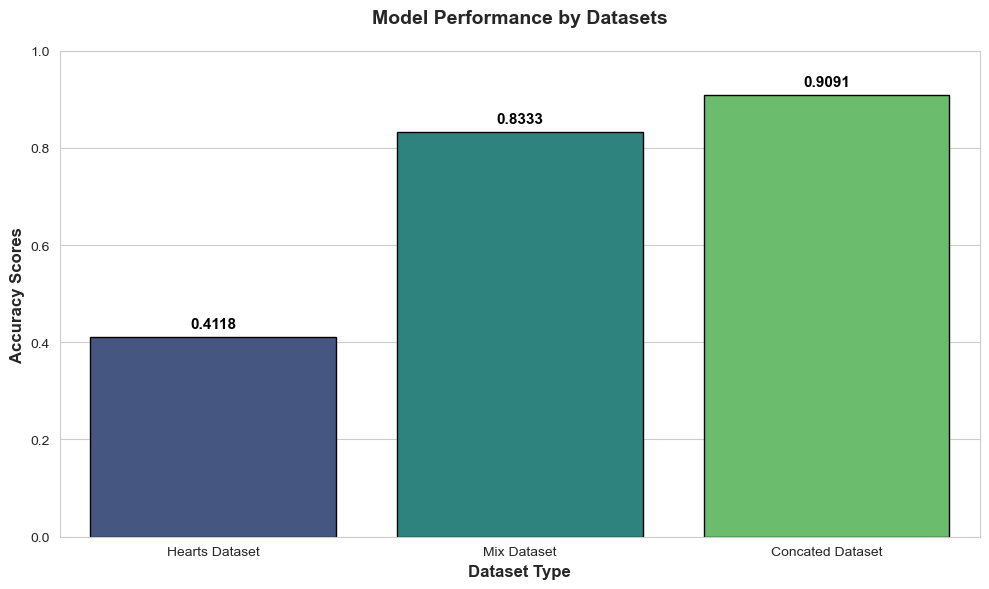

In [70]:
scores = [df_hearts_score, df_mix_score, df_concated_score]
labels = ["Hearts Dataset", "Mix Dataset", "Concated Dataset"]

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(x=labels, y=scores, palette="viridis", edgecolor="black")

plt.ylim(0, 1.0)

plt.xlabel("Dataset Type", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy Scores", fontsize=12, fontweight='bold')
plt.title("Model Performance by Datasets", fontsize=14, pad=20, fontweight='bold')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

In [71]:
# En verimli veri setinin, iki veri setinin birleşimi olan (df_concated) veri seti olduğunu görmüş olduk. Model geliştirmeye birleştirilmiş veri setiyle devam edeceğiz.
# We have seen that the most efficient dataset is the df_concated dataset, which is a combination of two datasets. We will continue model development with the concatenated dataset.

# Hyperparameter Tuning

In [72]:
X_train.head()

# Güncel olarak test ve train veri setleri encoding ve scaling yapılmış halde; kullanacak olduğumuz df_concated veri setinden meydana getirildiği için tekrardan herhangi bir ön hazırlığa gerek yoktur.
# Currently, the test and training datasets have already undergone encoding and scaling; since they are created from the df_concated dataset we will be using, no further preparation is necessary.

,encoding__Gender_F,encoding__Gender_M,scaling__zcr_mean,scaling__zcr_std,scaling__spactral_centroid_mean,scaling__spactral_centroid_std,scaling__mfcc_mean_0,scaling__mfcc_std_0,scaling__delta_mean_0,scaling__delta2_mean_0,...,scaling__delta2_mean_19,remainder__anterior,remainder__apex,remainder__carotid,remainder__left,remainder__lower,remainder__mid,remainder__right,remainder__sternal_border,remainder__upper
116,1.00,0.00,-0.47,-0.11,-0.32,0.91,-0.66,-0.20,-1.20,-0.60,...,0.08,1,0,0,0,0,0,1,0,1
151,0.00,1.00,-0.84,-0.87,-0.77,-0.48,-0.91,-0.40,-1.12,1.00,...,0.48,1,0,0,0,1,0,1,0,0
59,1.00,0.00,-0.36,-0.31,0.16,0.18,1.73,-1.07,0.77,-1.35,...,-0.58,1,0,0,1,0,0,0,0,1
42,0.00,1.00,1.20,2.27,1.34,2.09,0.35,-0.22,0.31,-0.36,...,0.16,0,0,1,0,0,0,1,0,0
17,0.00,1.00,0.45,-0.11,0.41,-0.78,0.02,-0.62,0.06,1.10,...,-1.08,0,0,0,1,0,0,0,1,1


In [73]:
from sklearn.model_selection import RandomizedSearchCV

In [74]:
params = {
    
    'n_estimators': [100, 500, 1000, 2000],
    'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 150],
    'max_depth': [-1, 5, 10, 15, 20],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'min_child_samples': [5, 10, 20, 30, 50],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': [None, 'balanced'],
}

In [75]:
rnd = RandomizedSearchCV(estimator=LGBMClassifier(verbosity=-1), param_distributions=params, cv=5, verbose=1, n_jobs=-1)

In [76]:
rnd.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifier(verbosity=-1)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'class_weight': [None, 'balanced'], 'colsample_bytree': [0.6, 0.7, ...], 'learning_rate': [0.005, 0.01, ...], 'max_depth': [-1, 5, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used h

In [77]:
rnd.best_params_

{'subsample': 1.0,
 'num_leaves': 30,
 'n_estimators': 1000,
 'min_child_samples': 30,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6,
 'class_weight': None}

In [78]:
lgbm = LGBMClassifier(
    
    subsample=0.8, 
    num_leaves= 30,
    n_estimators=1000,
    min_child_samples=20,
    max_depth=15,
    learning_rate=0.05,
    colsample_bytree=0.7,
    class_weight=None,
    verbosity=-1)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
y_pred_train = lgbm.predict(X_train)

print("Train Scores: \n")
print("Accuracy Score: ", accuracy_score(y_train, y_pred_train), "\n")
print(classification_report(y_train, y_pred_train), "\n")
print("Test Scores: \n")
print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Train Scores: 

Accuracy Score:  1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140
 

Test Scores: 

Accuracy Score:  0.9090909090909091 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.60     

In [79]:
# Görüldüğü üzere model overfit olmuş durumda. L1 ve L2 ceza optimizasyonları ile daha makul bir duruma getirmeye çalışacağız.
# As you can see, the model is overfitted. We will try to make it more reasonable by optimizing the L1 and L2 penalties.

In [80]:
lgbm = LGBMClassifier(reg_alpha=3, reg_lambda=1, verbosity=-1)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
y_pred_train = lgbm.predict(X_train)

print("Train Scores: \n")
print("Accuracy Score: ", accuracy_score(y_train, y_pred_train), "\n")
print(classification_report(y_train, y_pred_train), "\n")
print("Test Scores: \n")
print("Accuracy Score: ", accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))


# Manuel denemelerden sonra en optimize L1 ve L2 ceza katsayıları ile modelin öğrenim durumu daha dengeli bir hale getirildi.
# After manual testing, the model's learning state was stabilized with the most optimized L1 and L2 penalty coefficients.

Train Scores: 

Accuracy Score:  0.95 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.92      0.86      0.89        14
           2       1.00      0.93      0.96        14
           3       0.93      0.93      0.93        14
           4       1.00      1.00      1.00        16
           5       0.93      0.93      0.93        15
           6       0.94      0.94      0.94        16
           7       0.93      1.00      0.97        14
           8       0.93      1.00      0.96        13
           9       1.00      0.92      0.96        13

    accuracy                           0.95       140
   macro avg       0.95      0.95      0.95       140
weighted avg       0.95      0.95      0.95       140
 

Test Scores: 

Accuracy Score:  0.8363636363636363 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.60    

# Pipeline Creation and Model Export

In [81]:
from sklearn.pipeline import Pipeline

In [82]:
model = Pipeline([
    
    ("sound_feature_extraction", SoundFeatureExtraction()),
    ("location_feature_extraction", LocationFeatureExtraction()),
    ("encoder_scaler", ColumnTransformer(transformers=[
    
                ("encoding", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Gender"]),
                ("scaling", StandardScaler(), make_column_selector(pattern="^zcr|spactral|mfcc|delta|delta2.*"))], remainder="passthrough")),
    
    ("classifier", LGBMClassifier(reg_alpha=3, reg_lambda=1, verbosity=-1))
    
])

In [83]:
df_concated

,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB
...,...,...,...,...
190,M,S4,Apex,H0141
191,F,Mid Systolic Murmur,RMA,H0142
192,F,Early Systolic Murmur,RLA,H0143
193,F,AV Block,LUA,H0144


In [84]:
label_encoding = LabelEncoder()
df_concated["Heart Sound Type"] = label_encoding.fit_transform(df_concated["Heart Sound Type"])

In [85]:
X_final = df_concated.drop(columns="Heart Sound Type")
y_final = df_concated["Heart Sound Type"]

In [86]:
X_final

,Gender,Location,Heart Sound ID
0,F,RC,F_N_RC
1,F,LC,F_N_LC
2,M,RUSB,M_N_RUSB
3,F,LUSB,F_N_LUSB
4,F,LLSB,F_N_LLSB
...,...,...,...
190,M,Apex,H0141
191,F,RMA,H0142
192,F,RLA,H0143
193,F,LUA,H0144


In [87]:
y_final

0      6
1      6
2      6
3      6
4      6
      ..
190    8
191    5
192    2
193    0
194    3
Name: Heart Sound Type, Length: 195, dtype: int64

In [88]:
# En son adımda "dışarıdan yeni gelecek olan ses kayıtlarını tahmin etme" senaryosu doğrultusunda modeli elimizdeki tüm veri setiyle eğitiyoruz.
# In the final step, we train the model with the entire dataset available, in line with the scenario of "predicting new audio recordings that will be received from outside."

model.fit(X_final, y_final)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('sound_feature_extraction', ...), ('location_feature_extraction', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('encoding', ...), ('scaling', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, de

In [89]:
pipeline_testing = {

    "Gender" : "M",
    "Location" : "RUSB",
    "Heart_Sound_ID" : "H0142"
    
}

test_input = pd.DataFrame([pipeline_testing])
pred_model = model.predict(test_input)

print(pred_model)
print(label_encoding.inverse_transform(pred_model)[0])

[5]
Mid Systolic Murmur


In [90]:
import joblib

In [91]:
joblib.dump(model, "model_heart_disease_prediction.pkl") # Model export
joblib.dump(label_encoding, "encoder_heart_disease_prediction.pkl") # Encoder export

['encoder_heart_disease_prediction.pkl']

In [92]:
model_input = joblib.load("model_heart_disease_prediction.pkl") # Model import
encoder_input = joblib.load("encoder_heart_disease_prediction.pkl") # Encoder import

In [93]:
# İçe aktarılan modeli test etme.
# Testing the imported model.

model_testing = {

    "Gender" : "F",
    "Location" : "Apex",
    "Heart_Sound_ID" : "F_AF_A"
    
}

test_input = pd.DataFrame([model_testing])
pred_model = model_input.predict(test_input)

print(pred_model)
print(encoder_input.inverse_transform(pred_model)[0])

[1]
Atrial Fibrillation


In [94]:
!pip install pipreqsnb -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 6.1.0 requires ipython!=8.17.1,!=9.1.0,!=9.2.0,!=9.3.0,!=9.4.0,<10.0.0,>=8.15.0, but you have ipython 8.12.3 which is incompatible.
spyder-kernels 3.1.2 requires ipython!=8.17.1,!=9.1.0,!=9.2.0,!=9.3.0,!=9.4.0,<10,>=8.15.0, but you have ipython 8.12.3 which is incompatible.


In [95]:
!pipreqsnb . --force

# requirements.txt created.

pipreqs  --force .
INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in ./requirements.txt


In [96]:
import sys
print(sys.version)

3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:07:49) [Clang 20.1.8 ]
